<a href="https://colab.research.google.com/github/effepivi/gvxr-tutorials/blob/main/gVXR2CIL/NOTEBOOKS/GenerateIllustrationSlide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

? 

<!-- # Session 7

## Simulating X-ray images with specific Poisson noise using ![gVXR](https://github.com/effepivi/gvxr-tutorials/blob/main/img/gvxr_logo.png?raw=1)

## Author: Franck Vidal

(version 1.0, 10 Mar 2023) -->

?

<!-- # Aims of this session

1. Add Poisson noise corresponding to a given number of photons per pixel;
2. Simulate the corresponding CT scan; and
3. Reconstruct the CT volume using the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/). -->

?

<!-- # Main steps

1. Simulate an X-ray projection of a Welsh dragon made of quartz

![Simulation of an X-ray projection of a Welsh dragon made of quartz](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/visualisation.png?raw=1)

2. Select the number of incident photons per pixel
3. Add the corresponding amount of Photonic noise 

![X-ray projection with Poisson noise](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/noisy-projection.png?raw=1)

4. Simulate a CT scan

![Scanning eometry](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/CT-geometry.png?raw=1)

5. Create the flat-field images with the corresponding amount of Photonic noise

![Average flat-field image with Poisson noise](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/average-flat-field.png?raw=1)

6. Reconstruct the CT volume using the [Core Imaging Library (CIL)](https://ccpi.ac.uk/cil/)

![Visualisation of the reconstructed 3D volume](https://github.com/effepivi/gvxr-tutorials/blob/main/PoissonNoise/plotCT.png?raw=1) -->

In [1]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

?

<!-- # Install gVXR, k3D, imagecodecs xpecgen, spekpy and SimpleITK

Run the cell below

```python
!pip3 install gvxr k3d imagecodecs xpecgen git+https://bitbucket.org/spekpy/spekpy_release.git SimpleITK #itk-rtk
``` -->

In [2]:
# !pip3 install gvxr k3d imagecodecs xpecgen git+https://bitbucket.org/spekpy/spekpy_release.git SimpleITK #itk-rtk

In [3]:
# !mamba install -c conda-forge -c intel -c astra-toolbox -c ccpi cil numpy astra-toolbox --quiet

In [4]:
%matplotlib inline

# Copy files

This step is needed when the notebook is executed using Goggle Collaborative

Download the Sample if needed

In [5]:
import os
import urllib.request
import matplotlib.pyplot as plt # Plotting

output_path = "../output_data/Illustrations"

def createDirectory(directory):
    # The directory does not exist
    if not os.path.exists(os.path.abspath(directory)):
    
        # Create the directory
        os.mkdir(os.path.abspath(directory))

def downloadFile(fname):
    if not os.path.exists(fname):
        base_url = "https://github.com/effepivi/gvxr-tutorials/raw/main"
        url = base_url + "/" + fname
        print("Download the polygon mesh (%s)" % fname)
        urllib.request.urlretrieve(url, fname)

createDirectory("../JSON")
createDirectory("../input_data")
createDirectory("../output_data")
createDirectory(output_path)

# downloadFile("input_data/welsh-dragon-small.stl")
# downloadFile("energyResponseDetector.txt")
# downloadFile("JSON/PoissonNoise.json")
# downloadFile("output_data/visualisation.png")

In [6]:
import os
import numpy as np
import SimpleITK as sitk

import matplotlib
import matplotlib.pyplot as plt # Plotting

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 25.5
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

has_cil = True
try:
    from gvxrPython3.JSON2gVXRDataReader import *
    from cil.recon import FDK
    from cil.plugins.astra.processors.FDK_Flexible import FDK_Flexible
    from cil.processors import TransmissionAbsorptionConverter
    from cil.utilities.display import show_geometry
    from cil.utilities.jupyter import islicer
    print("CIL detected")
except:
    has_cil = False
    print("CIL not detected")
    
has_tigre = True
try:
    import tigre
    print("Tigre detected")
except:
    has_tigre = False
    print("Tigre not detected")

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr
from gvxrPython3.utils import plotScreenshot

xpecgen is not install, you won't be able to load a beam spectrum using xpecgen
SimpleGVXR 2.0.5 (2023-03-09T10:48:45) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.5 (2023-03-09T10:48:44) [Compiler: GNU g++] on Linux
CIL detected
Tigre detected


In [7]:
json_fname = "../JSON/Slide.json"

## Initialise GVXR using our JSON file

In [8]:
json2gvxr.initGVXR(json_fname, renderer="OPENGL")

Create an OpenGL context: 900x350


Mon Mar 20 15:18:05 2023 ---- Create window (ID: -1)
Mon Mar 20 15:18:05 2023 ---- Initialise GLFW
Mon Mar 20 15:18:05 2023 ---- Create an OpenGL window with a 3.2 context.
Mon Mar 20 15:18:05 2023 ---- Make the window's context current
Mon Mar 20 15:18:05 2023 ---- Initialise GLEW
Mon Mar 20 15:18:05 2023 ---- OpenGL vendor: NVIDIA Corporation
Mon Mar 20 15:18:05 2023 ---- OpenGL renderer: NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
Mon Mar 20 15:18:05 2023 ---- OpenGL version: 3.2.0 NVIDIA 515.76
Mon Mar 20 15:18:05 2023 ---- Use OpenGL 4.5.
Mon Mar 20 15:18:05 2023 ---- Initialise the X-ray renderer if needed and if possible


In [9]:
json2gvxr.initSamples(verbose=1)
gvxr.moveToCentre()

ID = "root"
min_x, min_y, min_z, max_x, max_y, max_z = gvxr.getNodeAndChildrenBoundingBox(ID, "mm")

centre_x = (min_x + max_x) / 2.0
centre_y = (min_y + max_y) / 2.0
centre_z = (min_z + max_z) / 2.0

print("Bounding box:", [min_x, min_y, min_z], [max_x, max_y, max_z])
print("Bounding box centre:", [centre_x, centre_y, centre_z])

Load the 3D data

	Load internals in /home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/internals.stl using mm
	Load front_flange in /home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/front_flange.stl using mm
	Load rear_flage in /home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/rear_flange.stl using mm
	Load housing in /home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/housing.stl using mm
	Load roller_bearing in /home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/ThrustRollerBearing.stl using mm
Bounding box: [-28.82575225830078, -29.8372802734375, -19.06999969482422] [28.825754165649414, 29.8372802734375, 19.07000160217285]
Bounding box centre: [9.5367431640625e-07, 0.0, 9.5367431640625e-07]


Mon Mar 20 15:18:06 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/internals.stl	nb_faces:	86276	nb_vertices:	258828	bounding_box (in cm):	(-3.48613, -5.55, -3.48613)	(3.48613, -0.735, 3.48613)
Mon Mar 20 15:18:06 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/front_flange.stl	nb_faces:	6120	nb_vertices:	18360	bounding_box (in cm):	(-11.425, 0, -11.425)	(11.425, 3.535, 11.425)
Mon Mar 20 15:18:06 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/rear_flange.stl	nb_faces:	10516	nb_vertices:	31548	bounding_box (in cm):	(-11.425, -15.535, -11.425)	(11.425, -6.73, 11.425)
Mon Mar 20 15:18:06 2023 ---- file_name:	/home/fpvidal/PROGRAMMING/GitHub/gVXR2CIL/JSON/../input_data/TurboPump/housing.stl	nb_faces:	35076	nb_vertices:	105228	bounding_box (in cm):	(-12.3086, -8.5025, -14.9408)	(16.5171, 1.8975, 14.8965)
Mon Mar 20 15:18:06 2023 ---- file_name:	/home/fpvidal

In [10]:
spectrum, unit_of_energy, energy_set, bin_sets = json2gvxr.initSpectrum(verbose=0)

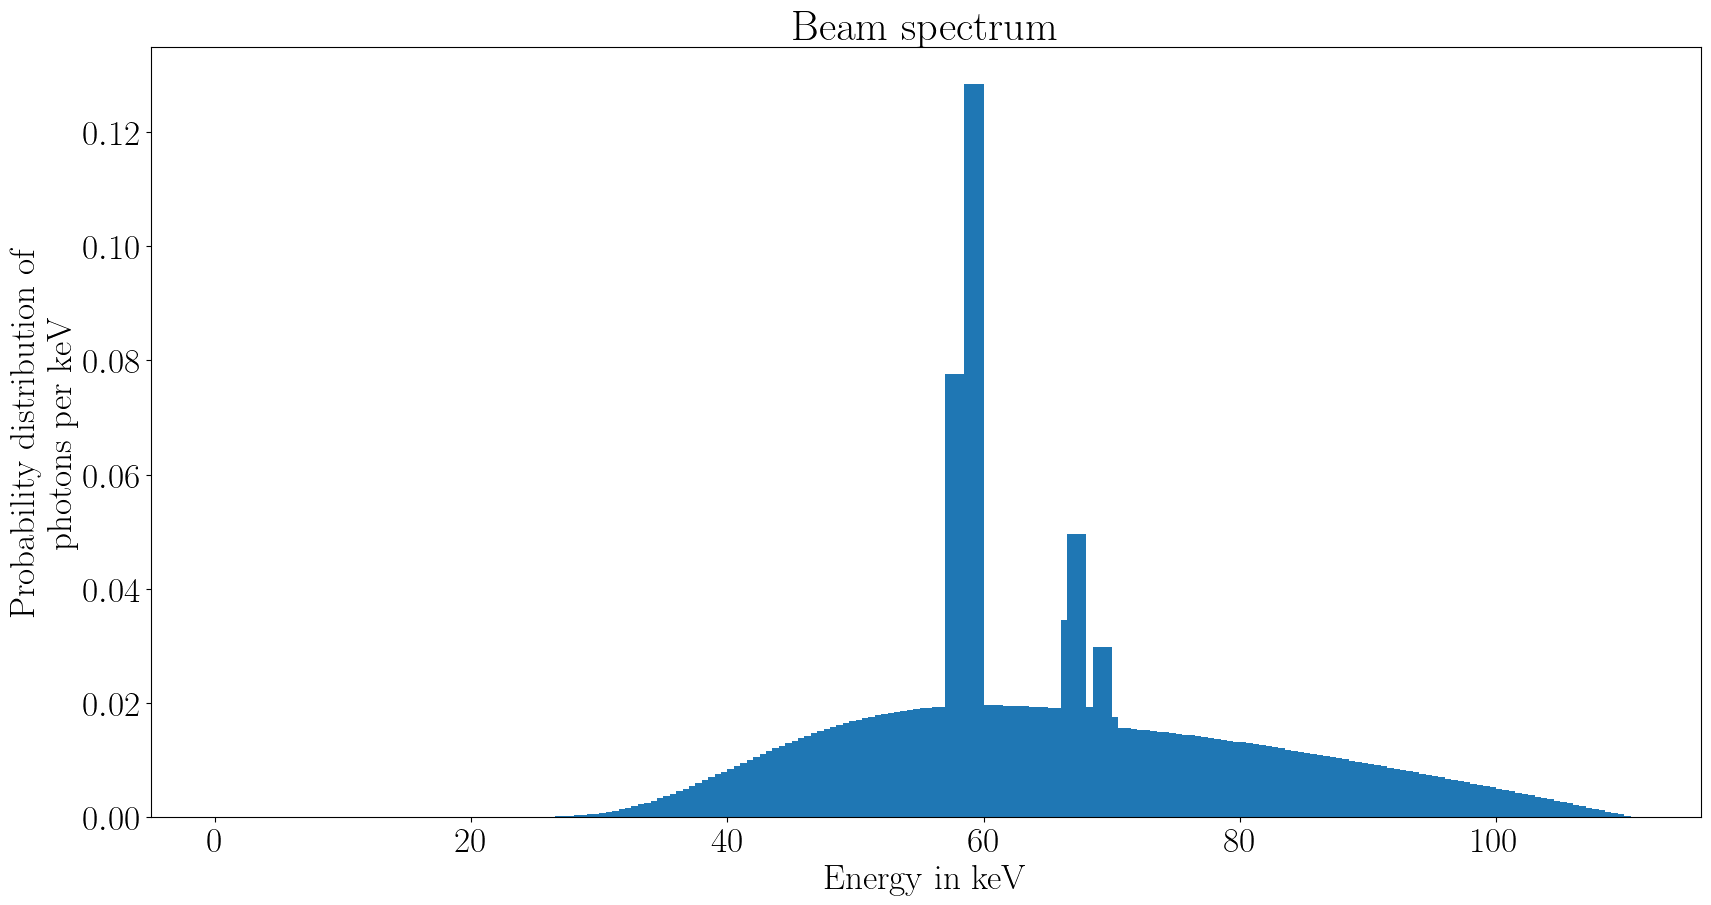

In [11]:
plt.figure(figsize= (20,10))
plt.title("Beam spectrum")
plt.bar(energy_set, bin_sets, width=1)
plt.xlabel('Energy in ' + unit_of_energy)
plt.ylabel('Probability distribution of\n photons per keV')
plt.savefig(output_path + "/spectrum.png")

In [12]:
json2gvxr.initDetector()
json2gvxr.initSourceGeometry()

Set up the detector
	Detector position: [-150, 0, 0, 'mm']
	Detector up vector: [0, 0, 1]
	Number of pixels: [900, 900]
	Detector number of pixels: [900, 900]
	Pixel spacing: [0.2, 0.2, 'mm']
Set up the beam
	Source position: [200, 0, 0, 'mm']
	Source shape: Point


Mon Mar 20 15:18:07 2023 ---- Initialise the renderer


In [13]:
zoom = 350

gvxr.displayScene()
gvxr.setZoom(zoom)
gvxr.displayScene()

matrix = gvxr.getSceneRotationMatrix()

In [14]:
gvxr.setWindowBackGroundColour(1,1,1)
gvxr.displayBeam(False)
gvxr.displayScene()

In [15]:
fname = output_path + '/s0.png'

if not os.path.exists(fname):
    screenshot = np.array(gvxr.takeScreenshot(), dtype=np.single)
    matplotlib.image.imsave(fname, screenshot)

In [16]:
fname = output_path + '/s2.png'

if not os.path.exists(fname):
    screenshot = np.array(gvxr.takeScreenshot(), dtype=np.single)
    matplotlib.image.imsave(fname, screenshot)

In [17]:
gvxr.displayBeam(True)
gvxr.displayScene()

In [18]:
fname = output_path + '/s3.png'

if not os.path.exists(fname):
    screenshot = np.array(gvxr.takeScreenshot(), dtype=np.single)
    matplotlib.image.imsave(fname, screenshot)

In [19]:
projection_in_MeV = np.array(gvxr.computeXRayImage(), dtype=np.single)
projection_in_keV = projection_in_MeV / gvxr.getUnitOfEnergy("keV")
gvxr.displayScene()

In [20]:
fname = output_path + '/s4.png'

if not os.path.exists(fname):
    screenshot = np.array(gvxr.takeScreenshot(), dtype=np.single)
    matplotlib.image.imsave(fname, screenshot)

In [21]:
json2gvxr.initScan()
gvxr.setSceneRotationMatrix(matrix)
gvxr.setZoom(zoom)

Set up the CT Scan


In [22]:
if not os.path.exists(json2gvxr.getFilePath(json2gvxr.params["Scan"]["GifPath"])):
    angles = json2gvxr.doCTScan(verbose=False)

# CT  reconstruction

In [23]:
def reconstructFBPWithCIL(data, ig, verbose):
    if verbose > 0: print("Parallel beam detected")

    if has_tigre:
        if verbose > 0: print("Backend: Tigre")
        reconstruction:ImageData | None = FBP(data, ig).run()
    else:
        if verbose > 0: print("Backend: Astra-Toolbox")
        reconstruction:ImageData | None = FBP(data, ig, backend="astra").run()

    return reconstruction

In [24]:
def reconstructFDKWithCIL(data, ig, verbose):
    if verbose > 0: print("Cone beam detected")

    if has_tigre:
        if verbose > 0: print("Backend: Tigre")
        reconstruction:ImageData | None = FDK(data, ig).run()
    else:
        if verbose > 0: print("Backend: Astra-Toolbox")
        fbk = FDK_Flexible(ig, data.geometry)
        fbk.set_input(data)
        reconstruction:ImageData | None = fbk.get_output()
    
    return reconstruction

In [25]:
def reconstructFBPWithRTK(verbose):
    if verbose > 0: print("Parallel beam detected")
    if verbose > 0: print("Backend: RTK")
    
    raise ValueError("Not currently supported")
    
    return None

In [26]:
def reconstruct(JSON_fname, verbose=0):
    
    json2gvxr.initScan(JSON_fname)

    data = None
    reconstruction = None
    
    source_shape = json2gvxr.params["Source"]["Shape"]

    if verbose > 0:
        print("Source shape:", source_shape)

        # Use CIL
    if has_cil:
    
        if verbose > 0: print("Use CIL")

        reader = JSON2gVXRDataReader(file_name=JSON_fname)
        data = reader.read()

        print("data.geometry", data.geometry)
        
        if has_tigre:
            data.reorder(order='tigre')
            data.geometry.set_angles(-data.geometry.angles)
        else:
            data.reorder("astra")

        ig = data.geometry.get_ImageGeometry()

        data_corr = TransmissionAbsorptionConverter(white_level=data.max(), min_intensity=0.000001)(data)

        if type(source_shape) == str:

            if source_shape.upper() == "PARALLELBEAM" or source_shape.upper() == "PARALLEL":
                reconstruction:ImageData | None = reconstructFBPWithCIL(data_corr, ig, verbose)

            elif source_shape.upper() == "POINTSOURCE" or source_shape.upper() == "POINT" or source_shape.upper() == "CONE" or source_shape.upper() == "CONEBEAM":
                reconstruction:ImageData | None = reconstructFDKWithCIL(data_corr, ig, verbose)

            else:
                raise ValueError("Unknown source shape:" + source_shape)

        elif type(source_shape) == type([]):
            if source_shape[0].upper() == "FOCALSPOT":
                reconstruction:ImageData | None = reconstructFDKWithCIL(data_corr, ig, verbose)

            else:
                raise ValueError("Unknown source shape:" + source_shape)

        else:
            raise ValueError("Unknown source shape:" + source_shape)    

    # Use ITK-RTK
    else:

        if verbose > 0: print("Use RTK")

        if type(source_shape) == str:

            if source_shape.upper() == "PARALLELBEAM" or source_shape.upper() == "PARALLEL":
                reconstruction = reconstructFBPWithRTK(verbose)
                
            elif source_shape.upper() == "POINTSOURCE" or source_shape.upper() == "POINT" or source_shape.upper() == "CONE" or source_shape.upper() == "CONEBEAM":
                reconstruction = reconstructFDKWithRTK(verbose)
                
            else:
                raise ValueError("Unknown source shape:" + source_shape)

        elif type(source_shape) == type([]):
            if source_shape[0].upper() == "FOCALSPOT":
                reconstruction = reconstructFDKWithRTK(verbose)

            else:
                raise ValueError("Unknown source shape:" + source_shape)

        else:
            raise ValueError("Unknown source shape:" + source_shape)    

    return data, reconstruction

In [27]:
data, reconstruction = reconstruct(json_fname, verbose=1)


# reader = JSON2gVXRDataReader(file_name=json_fname)
# data = reader.read()

Set up the CT Scan
Source shape: Point
Use CIL
[900, 900]
[0.2, 0.2]
data.geometry 3D Cone-beam tomography
System configuration:
	Source position: [-200.,    0.,    0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [150.,   0.,   0.]
	Detector direction x: [ 0., -1.,  0.]
	Detector direction y: [ 0.,  0., -1.]
Panel configuration:
	Number of pixels: [900 900]
	Pixel size: [0.2 0.2]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 181
	Angles 0-20 in degrees:
[ 0.       ,  1.9889503,  3.9779005,  5.9668508,  7.955801 ,  9.944752 ,
 11.9337015, 13.922652 , 15.911602 , 17.900553 , 19.889503 , 21.878452 ,
 23.867403 , 25.856354 , 27.845304 , 29.834253 , 31.823204 , 33.812153 ,
 35.801105 , 37.790054 ]
Distances in units: units distance
Cone beam detected
Backend: Tigre
FDK recon

Input Data:
	angle: 181
	vertical: 900
	horizontal: 900

Reconstruction Volume:
	vertical: 

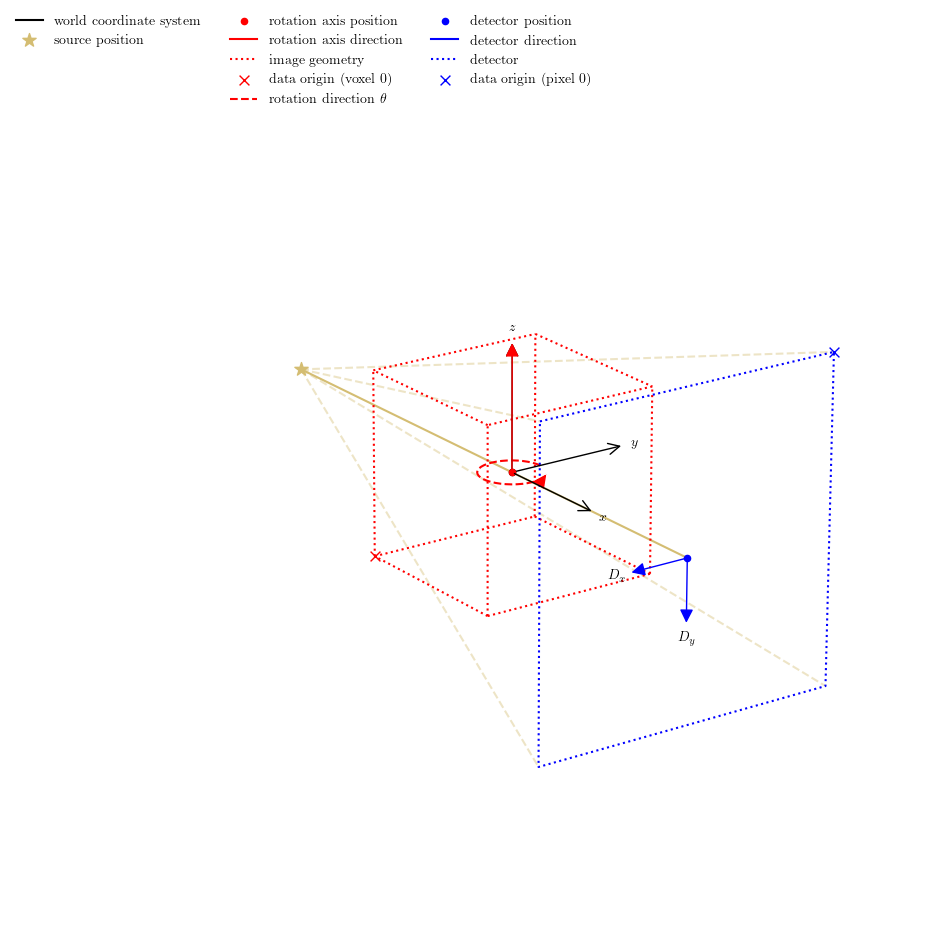

In [28]:
show_geometry(data.geometry)

In [29]:
data.reorder(order='tigre')
data_corr = TransmissionAbsorptionConverter(white_level=data.max())(data)

In [30]:
ig = data.geometry.get_ImageGeometry()

# ig.voxel_num_x = 600
# ig.voxel_num_y = 600
# ig.voxel_num_z = 700

recons = FDK(data_corr, ig).run()

FDK recon

Input Data:
	angle: 181
	vertical: 900
	horizontal: 900

Reconstruction Volume:
	vertical: 900
	horizontal_y: 900
	horizontal_x: 900

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



In [31]:
islicer(recons, direction='vertical')

In [32]:
islicer(recons, direction='horizontal_x')

In [33]:
fname = output_path + "/FDK.mha"

reconstruction_as_array = recons.as_array()

detector_size = np.array(gvxr.getDetectorSize("mm"))
number_of_pixels = np.array(gvxr.getDetectorNumberOfPixels())
spacing = detector_size / number_of_pixels
sitk_image = sitk.GetImageFromArray(reconstruction_as_array)
sitk_image.SetSpacing([spacing[0], spacing[0], spacing[1]])

In [34]:
sitk.WriteImage(sitk_image, fname, useCompression=True)

In [35]:
reconstruction_as_array[reconstruction_as_array<0.00001] = 0
reconstruction_as_array /= reconstruction_as_array.max()
reconstruction_as_array *= 255
reconstruction_as_array = reconstruction_as_array.astype(np.uint8)

In [36]:
def downsample(image, resize_factor):
    return image[::resize_factor, ::resize_factor]

In [37]:
resampled = []
resize_factor = 4

for i in range(reconstruction_as_array.shape[0]):
    if not i % resize_factor and i > 275 and i < reconstruction_as_array.shape[0] - 275:
        resampled.append(downsample(reconstruction_as_array[i], resize_factor))
        
resampled = np.array(resampled)

In [38]:
import imageio
fname = output_path + "/FDK.gif"
imageio.mimsave(fname, resampled)

In [39]:
gvxr.terminate()

Mon Mar 20 15:19:29 2023 ---- Destroy all the windows
Mon Mar 20 15:19:29 2023 ---- Destroy window 0(0x5655236fcdf0)
